# <font color='blue'><center>Forecasting stock price using Artificial Neural Network and Genetic Algorithm</center></font>

## Capstone Project

**Objective** - Forecasting stock prices is crucial in investment decision-making. Traditional statistics and artificial intelligence techniques are widely used to study price prediction. Stock prices exhibit non-linear dynamics, making it difficult to forecast through a single model. Therefore, there is a need to develop hybrid models to make more informed decisions. The main objective of this study is to forecast stock prices using Artificial Neural Network (ANN) combined with heuristic methods such as Genetic Algorithm (GA). We used technical indicators as neural network input features. In this research, the statistical population comprises three US market indices S&P500, DOW30, and NASDAQ100 for forecasting. Model performance is evaluated using Mean Absolute Percentage Error (MAPE) loss function.

**Data Source:** https://finance.yahoo.com/

In [1]:
# import the required libraries
from sinfo import sinfo
import re
import os
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

import pygad
import pygad.nn
import pygad.kerasga

In [2]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.3
ipykernel        : 6.28.0
ipywidgets       : 8.1.2
jupyter_client   : 8.6.0
jupyter_core     : 5.5.0
jupyter_server   : 1.13.5
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 7.16.3
nbformat         : 5.9.2
notebook         : 6.4.5
qtconsole        : 5.5.1
traitlets        : 5.7.1


In [3]:
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
keras       3.1.1
matplotlib  3.8.0
numpy       1.26.4
pandas      2.2.1
pygad       3.3.1
sinfo       0.3.4
sklearn     1.3.0
tensorflow  2.16.1
yfinance    0.2.37
-----
IPython             8.12.3
jupyter_client      8.6.0
jupyter_core        5.5.0
jupyterlab          3.3.2
notebook            6.4.5
-----
Python 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
4 logical CPU cores, Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
-----
Session information upda

In [4]:
# Index symbols
#Dow Jones Industrial Average - DJI
#S&P 500 - GSPC
#NASDAQ Composite - IXIC

sdate = "2019-01-01"
edate = "2023-12-31"
symbols = ['^DJI','^GSPC','^IXIC']

# Download data from yahoo finance
dfs = []
for symbol in symbols:
    yfdata = yf.download(symbol, start=sdate, end=edate)
    yfdata['Index'] = symbol
    dfs.append(yfdata)

# Concatenate the individual DataFrames into one
idx_data = pd.concat(dfs)
idx_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Index
Date,,,,,,,
2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,23346.240234,321570000,^DJI
2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,22686.220703,424240000,^DJI
2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,23433.160156,396020000,^DJI
2019-01-07,23474.259766,23687.740234,23301.589844,23531.349609,23531.349609,334200000,^DJI
2019-01-08,23680.320312,23864.650391,23581.449219,23787.449219,23787.449219,317420000,^DJI


In [5]:
#clean the Index name in the Index column
idx_data['Index'] = idx_data['Index'].apply(lambda x: re.sub("\^","",x) )
idx_data['Index'].value_counts()

Index
DJI     1258
GSPC    1258
IXIC    1258
Name: count, dtype: int64

### Check for data completeness i.e. zero datapoints or NA datapoints

In [6]:
(idx_data == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

Check for NA or Null datapoints

In [7]:
idx_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

In [8]:
# size
row = idx_data.shape[0]
print(row)

3774


**Observations** - There are no invalid datapoints in our dataset. We have checked for if any datapoint is 0 or Null. Now, we plot the Closing price timeseries for each index.

In [9]:
symbols1 = [re.sub("\^","", x ) for x in symbols]
symbols1

['DJI', 'GSPC', 'IXIC']

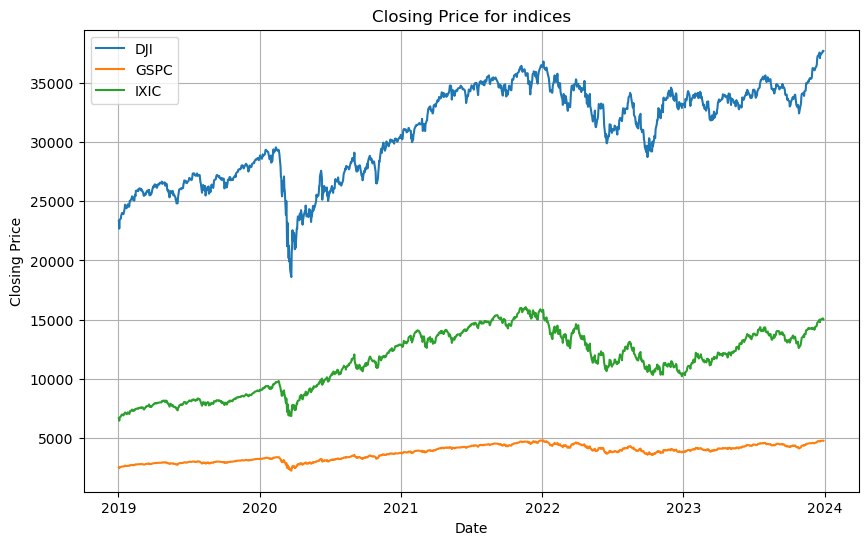

In [10]:
# Plot the closing price for each index
plt.figure(figsize=(10, 6))
for symbol in symbols1:
    ticker_data = idx_data[idx_data['Index'] == symbol]
    plt.plot(ticker_data.index, ticker_data['Close'], label=symbol)

plt.title('Closing Price for indices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

**Observation** - From the above figure, it can be observed that stock prices are highly non-linear in nature. Hence, they cannot be easily forecasted by any time-series based or simple linear regression models. We need more dynamic and complex model that can identify the hidden patterns in the dataset and better fit the non-linearity. For this study, we are analysing artificial neural networks (ANN) model to fit this dataset. Since, hybrid model performs better in modelling non-linear and complex relations. In addition, we will also use Genetic Algorithm (GA) model to improve the performance of simple ANN model.

### Derive technical indicators

Technical analysis is a tool to forecast direction of security prices through past prices and volume data. Technical analysts say that the market price reflects all information. So, they look at security’s historical trading pattern and forecast the direction rather than company fundamentals and news events. Security prices move in trends i.e. either price can go up, down or move sideways. Technical analyst believes that history tend to repeat itself and past trading patterns might appear again. 

There are various technical indicators developed to identify Trend, Momentum, Volume, Volatility and other combinations. In this study, we have chosen most important and commonly used technical indicators among traders and portfolio managers. The technical indicators are presented in the below table.



    1.	Open	          The open price
    2.	Low               The lowest price
    3.	High	          The highest price
    4.	Close             The closing price
    5.	Volume            Number of shares traded
    6.	SMA-5             5-days simple moving average
    7.	SMA-10	          10-days simple moving average
    8.	EMA-5             5-days exponential moving average
    9.	MP                Mean Price
    10.     TP	          Typical Price
    11.     RSI               Relative Strength Index
    12.     Williams %R       Williams Percent Range
    13.     Upper Band	  Upper Bolinger Band
    14.     Lower Band	  Lower Bolinger Band
    15.     ROC	          Rate of Change
    16.     ATR	          Average True Range	
    17.     ADL	          Accumulation distribution Line
    18.     MFI	          Money Flow Index
    19.     CCI	          Commodity Channel Index

In [11]:
# Compute technical indicators

# calculate simple moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns Simple moving average
def SMA(data, window):
    cname = 'SMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    return data

# calculate exponential moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns exponential moving average
def EMA(data, window):
    def cal_EMA(closepx, window):
        k = 2 / (window+1)
        nrow = closepx.size
        ema = [np.nan] * nrow
        ema[window - 1] = np.mean(closepx[:window])
        for i in range(window, nrow):
            ema[i] = (closepx.iloc[i] * k) + (ema[i - 1] * (1 - k))
        return ema
    cname = 'EMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].transform(lambda x: cal_EMA(x,window))
    return data

# calculate the Bollinger Bands
# Input - Close prices, Window: lookback period
# Output - Returns Bollinger Bands using Meand and SD
def Bollinger_bands(data, window):
    data["MA"] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    data["SD"] = data.groupby('Index')['Close'].rolling(window).std().reset_index(0, drop=True)
    data['UpperBand'] = data["MA"] + (2 * data["SD"] ) 
    data['LowerBand'] = data["MA"] - (2 * data["SD"] )
    data = data.drop(['MA', 'SD'], axis=1)
    return data

# calculate rate of change
# Input - Close prices, Window: lookback period
# Output - Returns the rate of change in closing price
def ROC(data, window):
    def cal_ROC(closepx, window):
        roc = closepx.pct_change(periods=window)
        return roc
    data['ROC'] = data.groupby('Index')['Close'].transform(lambda x: cal_ROC(x,window))
    return data

# calculate RSI values
# Input - Close prices, Window: lookback period
# Output - Relative strength indicator: measures the speed and change of price movements.
def RSI(data, window):
    def cal_RSI(closepx,window):
        diff = closepx.diff(1)
        up_direction = diff.where(diff > 0, 0.0)
        down_direction = -diff.where(diff < 0, 0.0)
        min_periods = window
        emaup = up_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        emadn = down_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        relative_strength = emaup / emadn
        rsi = pd.Series(
            np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
            index=closepx.index,
        )
        return rsi
    data['RSI'] = data.groupby('Index')['Close'].transform(lambda x: cal_RSI(x,window))
    return data


#Below indicators used more than one parameter in addition to Close. They also use High and Low prices.
# Volume based indicator also use Volume as their input

# Input - High, Low, Close prices, Window: lookback period
# Output - Williams %R reflects the level of the close relative to the highest high for the look-back period.
def williamsR(df,window):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    highest_high = high.rolling( window).max()  # highest high over the window
    lowest_low =  low.rolling(window  ).min()  # lowest low over the window
    wr = -100 * (highest_high - close) / (highest_high - lowest_low)
    return wr

# Input - High, Low, Close prices, Window: lookback period
# Output - ATR measures volatility, taking into account any gaps in the price movement.
def ATR(df, window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    pclose = df['Close'].shift(1)
    tr1 =    high - low
    tr2 = (high - pclose).abs()
    tr3 = (low - pclose).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    atr = np.full(len(close), np.nan)
    atr[window - 1] = true_range[0 : window].mean()
    for i in range(window, len(atr)):
        atr[i] = (atr[i - 1] * (window - 1) + true_range.iloc[i]) / float( window )
    #atr = pd.Series(data=atr)
    return atr

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - ADI identify divergences between the stock price and the volume flow.
def ADI(df):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    clv = ((close - low) - (high - close)) / ( high - low)
    clv = clv.fillna(0.0)  # float division by zero
    adi = clv * volume
    adi = adi.cumsum()
    return adi

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - MFI tells traders if there is a higher buying or selling pressure in the market
def MFI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    TP = (high + low + close) / 3.0
    up_down = np.where( TP > TP.shift(1), 1, np.where(TP < TP.shift(1), -1, 0),)
    mfr = TP * volume * up_down

    n_positive_mf = mfr.rolling(window).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True )
    n_negative_mf = abs(mfr.rolling(window).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))
    
    mfi = n_positive_mf / n_negative_mf
    mfi = 100 - (100 / (1 + mfi))
    
    return mfi

# Input - High, Low, Close prices. Window: lookback period
# Output - CCI measures the current price level relative to an average price level
def CCI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    TP = (high + low + close) / 3.0
    constant = 0.015
    def _mad(x):
        return np.mean(np.abs(x - np.mean(x)))
    
    cci = ( TP - TP.rolling(window).mean() ) / (
            constant  * TP.rolling(window).apply( _mad, True  )
    )
    return cci

In [12]:
#calculate technical indicator for each index

idx_data["MP"] =  (idx_data["High"] + idx_data["Low"]  ) / 2.0
idx_data["TP"] = (idx_data["High"] + idx_data["Low"] + idx_data["Close"]  ) / 3.0
idx_data = SMA(idx_data,5)
idx_data = SMA(idx_data,10)
idx_data = EMA(idx_data,5)
idx_data = RSI(idx_data,20)
idx_data = Bollinger_bands(idx_data,20)
idx_data = ROC(idx_data,1)

In [13]:
# Now, separate each index data from the combined data 
dow    = idx_data[idx_data["Index"] == "DJI"]
sp5    = idx_data[idx_data["Index"] == "GSPC"]
nasdaq = idx_data[idx_data["Index"] == "IXIC"]

with pd.option_context('mode.chained_assignment', None):
    
    #calculate technical indicators where more than one price parameter [Close] is used.
    dow["WR"] = williamsR(dow,14)
    dow["ATR"] = ATR(dow,14)
    dow["ADI"] = ADI(dow)
    dow["MFI"] = MFI(dow,14)
    dow["CCI"] = CCI(dow,20)

    sp5["WR"] = williamsR(sp5,14)
    sp5["ATR"] = ATR(sp5,14)
    sp5["ADI"] = ADI(sp5)
    sp5["MFI"] = MFI(sp5,14)
    sp5["CCI"] = CCI(sp5,20)

    nasdaq["WR"] = williamsR(nasdaq,14)
    nasdaq["ATR"] = ATR(nasdaq,14)
    nasdaq["ADI"] = ADI(nasdaq)
    nasdaq["MFI"] = MFI(nasdaq,14)
    nasdaq["CCI"] = CCI(nasdaq,20)
    
    # Target price is next day closing price
    dow['Targetprice']    = dow['Close'].shift(-1)
    sp5['Targetprice']    = sp5['Close'].shift(-1)
    nasdaq['Targetprice'] = nasdaq['Close'].shift(-1)

In [14]:
dow.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Index', 'MP',
       'TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI', 'Targetprice'],
      dtype='object')

In [15]:
# Remove NAN or NA values from the dataframe
with pd.option_context('mode.chained_assignment', None):
    dow.dropna(inplace=True)
    sp5.dropna(inplace=True)
    nasdaq.dropna(inplace=True)

In [16]:
dow.shape

(1238, 22)

In [17]:
dow_vol = "{:.2f}".format(100* np.sqrt(252)* dow['ROC'].std() )
sp5_vol = "{:.2f}".format(100* np.sqrt(252)* sp5['ROC'].std() )
nasdaq_vol = "{:.2f}".format(100*  np.sqrt(252)* nasdaq['ROC'].std() )

In [18]:
print(f"Dow index volatility is: {dow_vol}%")
print(f"S&P500 index volatility is: {sp5_vol}%")
print(f"Nasdaq index volatility is: {nasdaq_vol}%")

Dow index volatility is: 20.94%
S&P500 index volatility is: 21.36%
Nasdaq index volatility is: 25.17%


**Result** - It can be clearly seen that Dow index is least volatile compared to other two indices. Nasdaq index was more volatile during the analysis period.

### Artifical Neural Network (ANN) Training

We will train the ANN model on the Dow index. We have 19 features in the input layer. Output layer consist of 1 Node i.e. predicted closing price. Dow index had total 1239 rows. Out of this 80% data is used for training and 20% data is used for out-of-sample testing. Input features are scaled using StandardScaler to bring all the features on a same scale. This results in a dataset with normalized values represented using Z-score.

**ANN Parameters**

    1	Scaling            StandardScaler
    2	Train-test Split   80% Training and 20% Testing
    3	Activation         ReLU (Rectified linear activation)
    4	Optimiser          Adam (Adaptive moment estimation)
    5       Loss function      MAPE (Mean absolute percentage error)
    6       Epochs             400
    7       Batch Size         64

In [19]:
# define ANN model
# Input - Pandas Dataframe
# Output - Returns a trained model
def ANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']
    #X = dow[['Open', 'High', 'Low', 'Volume','Close','MP','TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
    #       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI']]

    # Scale the input features using MinMax scaling
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    # number of independent predictors
    n_cols = X.shape[1]
    
    # create Sequential model
    tf.keras.backend.clear_session()
    #tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(40, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    
    # fit the model
    epochs = 400
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = 64,verbose=2)
    
    return history, model,X_train, y_train, X_test, y_test

In [20]:
history_dow,model_dow, X_train_dow, y_train_dow,X_test_dow,y_test_dow = ANN_model(dow)
history_sp5,model_sp5, X_train_sp5, y_train_sp5,X_test_sp5,y_test_sp5 = ANN_model(sp5)
history_nasd,model_nasd,X_train_nasd, y_train_nasd,X_test_nasd,y_test_nasd = ANN_model(nasdaq)

(990, 19) (248, 19) (990,) (248,)

Epoch 1/400


C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 - 2s - 101ms/step - loss: 99.9987
Epoch 2/400
16/16 - 0s - 4ms/step - loss: 99.9952
Epoch 3/400
16/16 - 0s - 4ms/step - loss: 99.9891
Epoch 4/400
16/16 - 0s - 4ms/step - loss: 99.9778
Epoch 5/400
16/16 - 0s - 3ms/step - loss: 99.9587
Epoch 6/400
16/16 - 0s - 4ms/step - loss: 99.9255
Epoch 7/400
16/16 - 0s - 4ms/step - loss: 99.8691
Epoch 8/400
16/16 - 0s - 4ms/step - loss: 99.7737
Epoch 9/400
16/16 - 0s - 3ms/step - loss: 99.6183
Epoch 10/400
16/16 - 0s - 3ms/step - loss: 99.3825
Epoch 11/400
16/16 - 0s - 3ms/step - loss: 99.0505
Epoch 12/400
16/16 - 0s - 3ms/step - loss: 98.5841
Epoch 13/400
16/16 - 0s - 3ms/step - loss: 97.9621
Epoch 14/400
16/16 - 0s - 3ms/step - loss: 97.1606
Epoch 15/400
16/16 - 0s - 3ms/step - loss: 96.1104
Epoch 16/400
16/16 - 0s - 3ms/step - loss: 94.7998
Epoch 17/400
16/16 - 0s - 3ms/step - loss: 93.2045
Epoch 18/400
16/16 - 0s - 3ms/step - loss: 91.2595
Epoch 19/400
16/16 - 0s - 3ms/step - loss: 88.7918
Epoch 20/400
16/16 - 0s - 3ms/step - loss: 86.1012

Epoch 161/400
16/16 - 0s - 3ms/step - loss: 11.2956
Epoch 162/400
16/16 - 0s - 3ms/step - loss: 10.9410
Epoch 163/400
16/16 - 0s - 3ms/step - loss: 10.9459
Epoch 164/400
16/16 - 0s - 3ms/step - loss: 10.8395
Epoch 165/400
16/16 - 0s - 3ms/step - loss: 10.7511
Epoch 166/400
16/16 - 0s - 3ms/step - loss: 10.6122
Epoch 167/400
16/16 - 0s - 3ms/step - loss: 10.4784
Epoch 168/400
16/16 - 0s - 3ms/step - loss: 10.3304
Epoch 169/400
16/16 - 0s - 3ms/step - loss: 10.1063
Epoch 170/400
16/16 - 0s - 2ms/step - loss: 10.0361
Epoch 171/400
16/16 - 0s - 4ms/step - loss: 9.8879
Epoch 172/400
16/16 - 0s - 3ms/step - loss: 9.8508
Epoch 173/400
16/16 - 0s - 3ms/step - loss: 9.7674
Epoch 174/400
16/16 - 0s - 3ms/step - loss: 9.5020
Epoch 175/400
16/16 - 0s - 3ms/step - loss: 9.4441
Epoch 176/400
16/16 - 0s - 3ms/step - loss: 9.3523
Epoch 177/400
16/16 - 0s - 3ms/step - loss: 9.2418
Epoch 178/400
16/16 - 0s - 4ms/step - loss: 9.1973
Epoch 179/400
16/16 - 0s - 2ms/step - loss: 9.0575
Epoch 180/400
16/16 -

Epoch 322/400
16/16 - 0s - 3ms/step - loss: 1.0177
Epoch 323/400
16/16 - 0s - 3ms/step - loss: 1.0051
Epoch 324/400
16/16 - 0s - 3ms/step - loss: 1.0212
Epoch 325/400
16/16 - 0s - 2ms/step - loss: 1.0202
Epoch 326/400
16/16 - 0s - 3ms/step - loss: 1.0220
Epoch 327/400
16/16 - 0s - 3ms/step - loss: 0.9949
Epoch 328/400
16/16 - 0s - 4ms/step - loss: 1.0118
Epoch 329/400
16/16 - 0s - 4ms/step - loss: 0.9922
Epoch 330/400
16/16 - 0s - 3ms/step - loss: 0.9885
Epoch 331/400
16/16 - 0s - 3ms/step - loss: 1.0153
Epoch 332/400
16/16 - 0s - 3ms/step - loss: 0.9855
Epoch 333/400
16/16 - 0s - 4ms/step - loss: 0.9781
Epoch 334/400
16/16 - 0s - 3ms/step - loss: 0.9777
Epoch 335/400
16/16 - 0s - 5ms/step - loss: 0.9970
Epoch 336/400
16/16 - 0s - 4ms/step - loss: 0.9916
Epoch 337/400
16/16 - 0s - 4ms/step - loss: 0.9613
Epoch 338/400
16/16 - 0s - 4ms/step - loss: 0.9636
Epoch 339/400
16/16 - 0s - 4ms/step - loss: 0.9735
Epoch 340/400
16/16 - 0s - 3ms/step - loss: 0.9578
Epoch 341/400
16/16 - 0s - 3ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 - 1s - 78ms/step - loss: 100.0011
Epoch 2/400
16/16 - 0s - 3ms/step - loss: 99.9838
Epoch 3/400
16/16 - 0s - 3ms/step - loss: 99.9556
Epoch 4/400
16/16 - 0s - 3ms/step - loss: 99.9035
Epoch 5/400
16/16 - 0s - 4ms/step - loss: 99.8063
Epoch 6/400
16/16 - 0s - 3ms/step - loss: 99.6247
Epoch 7/400
16/16 - 0s - 4ms/step - loss: 99.3031
Epoch 8/400
16/16 - 0s - 3ms/step - loss: 98.7917
Epoch 9/400
16/16 - 0s - 3ms/step - loss: 97.9505
Epoch 10/400
16/16 - 0s - 4ms/step - loss: 96.7420
Epoch 11/400
16/16 - 0s - 3ms/step - loss: 94.8948
Epoch 12/400
16/16 - 0s - 3ms/step - loss: 92.3839
Epoch 13/400
16/16 - 0s - 3ms/step - loss: 88.8668
Epoch 14/400
16/16 - 0s - 3ms/step - loss: 84.1162
Epoch 15/400
16/16 - 0s - 3ms/step - loss: 77.9087
Epoch 16/400
16/16 - 0s - 3ms/step - loss: 70.0783
Epoch 17/400
16/16 - 0s - 3ms/step - loss: 60.9615
Epoch 18/400
16/16 - 0s - 4ms/step - loss: 54.0948
Epoch 19/400
16/16 - 0s - 3ms/step - loss: 51.6259
Epoch 20/400
16/16 - 0s - 3ms/step - loss: 49.2853

Epoch 162/400
16/16 - 0s - 3ms/step - loss: 1.6575
Epoch 163/400
16/16 - 0s - 3ms/step - loss: 1.6394
Epoch 164/400
16/16 - 0s - 3ms/step - loss: 1.5834
Epoch 165/400
16/16 - 0s - 4ms/step - loss: 1.5787
Epoch 166/400
16/16 - 0s - 5ms/step - loss: 1.5962
Epoch 167/400
16/16 - 0s - 4ms/step - loss: 1.5471
Epoch 168/400
16/16 - 0s - 4ms/step - loss: 1.5758
Epoch 169/400
16/16 - 0s - 4ms/step - loss: 1.4685
Epoch 170/400
16/16 - 0s - 5ms/step - loss: 1.4487
Epoch 171/400
16/16 - 0s - 3ms/step - loss: 1.4511
Epoch 172/400
16/16 - 0s - 4ms/step - loss: 1.4407
Epoch 173/400
16/16 - 0s - 5ms/step - loss: 1.4203
Epoch 174/400
16/16 - 0s - 4ms/step - loss: 1.3858
Epoch 175/400
16/16 - 0s - 4ms/step - loss: 1.3823
Epoch 176/400
16/16 - 0s - 3ms/step - loss: 1.3800
Epoch 177/400
16/16 - 0s - 4ms/step - loss: 1.3815
Epoch 178/400
16/16 - 0s - 3ms/step - loss: 1.3239
Epoch 179/400
16/16 - 0s - 5ms/step - loss: 1.3119
Epoch 180/400
16/16 - 0s - 4ms/step - loss: 1.2836
Epoch 181/400
16/16 - 0s - 4ms/

Epoch 323/400
16/16 - 0s - 3ms/step - loss: 0.9393
Epoch 324/400
16/16 - 0s - 3ms/step - loss: 0.9443
Epoch 325/400
16/16 - 0s - 3ms/step - loss: 0.9250
Epoch 326/400
16/16 - 0s - 3ms/step - loss: 0.9380
Epoch 327/400
16/16 - 0s - 3ms/step - loss: 0.9423
Epoch 328/400
16/16 - 0s - 4ms/step - loss: 0.9314
Epoch 329/400
16/16 - 0s - 3ms/step - loss: 0.9556
Epoch 330/400
16/16 - 0s - 3ms/step - loss: 0.9321
Epoch 331/400
16/16 - 0s - 3ms/step - loss: 0.9242
Epoch 332/400
16/16 - 0s - 4ms/step - loss: 0.9108
Epoch 333/400
16/16 - 0s - 3ms/step - loss: 0.9240
Epoch 334/400
16/16 - 0s - 3ms/step - loss: 0.9281
Epoch 335/400
16/16 - 0s - 3ms/step - loss: 0.9362
Epoch 336/400
16/16 - 0s - 3ms/step - loss: 0.9367
Epoch 337/400
16/16 - 0s - 4ms/step - loss: 0.9474
Epoch 338/400
16/16 - 0s - 3ms/step - loss: 0.9498
Epoch 339/400
16/16 - 0s - 3ms/step - loss: 0.9203
Epoch 340/400
16/16 - 0s - 3ms/step - loss: 0.9148
Epoch 341/400
16/16 - 0s - 4ms/step - loss: 0.9002
Epoch 342/400
16/16 - 0s - 3ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 - 1s - 88ms/step - loss: 99.9977
Epoch 2/400
16/16 - 0s - 3ms/step - loss: 99.9900
Epoch 3/400
16/16 - 0s - 3ms/step - loss: 99.9766
Epoch 4/400
16/16 - 0s - 3ms/step - loss: 99.9516
Epoch 5/400
16/16 - 0s - 4ms/step - loss: 99.8983
Epoch 6/400
16/16 - 0s - 4ms/step - loss: 99.7955
Epoch 7/400
16/16 - 0s - 4ms/step - loss: 99.6149
Epoch 8/400
16/16 - 0s - 3ms/step - loss: 99.3153
Epoch 9/400
16/16 - 0s - 4ms/step - loss: 98.8689
Epoch 10/400
16/16 - 0s - 4ms/step - loss: 98.1819
Epoch 11/400
16/16 - 0s - 3ms/step - loss: 97.1596
Epoch 12/400
16/16 - 0s - 4ms/step - loss: 95.8263
Epoch 13/400
16/16 - 0s - 4ms/step - loss: 94.0144
Epoch 14/400
16/16 - 0s - 4ms/step - loss: 91.6197
Epoch 15/400
16/16 - 0s - 3ms/step - loss: 88.5278
Epoch 16/400
16/16 - 0s - 3ms/step - loss: 84.5855
Epoch 17/400
16/16 - 0s - 3ms/step - loss: 79.7553
Epoch 18/400
16/16 - 0s - 4ms/step - loss: 73.9272
Epoch 19/400
16/16 - 0s - 3ms/step - loss: 67.0908
Epoch 20/400
16/16 - 0s - 4ms/step - loss: 60.7433


16/16 - 0s - 3ms/step - loss: 4.9858
Epoch 162/400
16/16 - 0s - 3ms/step - loss: 4.8159
Epoch 163/400
16/16 - 0s - 3ms/step - loss: 4.6700
Epoch 164/400
16/16 - 0s - 3ms/step - loss: 4.5299
Epoch 165/400
16/16 - 0s - 3ms/step - loss: 4.4038
Epoch 166/400
16/16 - 0s - 3ms/step - loss: 4.2604
Epoch 167/400
16/16 - 0s - 3ms/step - loss: 4.1563
Epoch 168/400
16/16 - 0s - 3ms/step - loss: 3.9650
Epoch 169/400
16/16 - 0s - 4ms/step - loss: 3.8793
Epoch 170/400
16/16 - 0s - 3ms/step - loss: 3.7329
Epoch 171/400
16/16 - 0s - 3ms/step - loss: 3.5991
Epoch 172/400
16/16 - 0s - 3ms/step - loss: 3.4782
Epoch 173/400
16/16 - 0s - 4ms/step - loss: 3.3132
Epoch 174/400
16/16 - 0s - 3ms/step - loss: 3.2168
Epoch 175/400
16/16 - 0s - 3ms/step - loss: 3.0890
Epoch 176/400
16/16 - 0s - 3ms/step - loss: 2.9825
Epoch 177/400
16/16 - 0s - 3ms/step - loss: 2.8574
Epoch 178/400
16/16 - 0s - 5ms/step - loss: 2.7599
Epoch 179/400
16/16 - 0s - 4ms/step - loss: 2.6575
Epoch 180/400
16/16 - 0s - 4ms/step - loss: 2

Epoch 322/400
16/16 - 0s - 3ms/step - loss: 1.1988
Epoch 323/400
16/16 - 0s - 3ms/step - loss: 1.1918
Epoch 324/400
16/16 - 0s - 3ms/step - loss: 1.1982
Epoch 325/400
16/16 - 0s - 3ms/step - loss: 1.1938
Epoch 326/400
16/16 - 0s - 4ms/step - loss: 1.1997
Epoch 327/400
16/16 - 0s - 3ms/step - loss: 1.2033
Epoch 328/400
16/16 - 0s - 3ms/step - loss: 1.1972
Epoch 329/400
16/16 - 0s - 3ms/step - loss: 1.1847
Epoch 330/400
16/16 - 0s - 3ms/step - loss: 1.1832
Epoch 331/400
16/16 - 0s - 3ms/step - loss: 1.1909
Epoch 332/400
16/16 - 0s - 3ms/step - loss: 1.2697
Epoch 333/400
16/16 - 0s - 4ms/step - loss: 1.1982
Epoch 334/400
16/16 - 0s - 3ms/step - loss: 1.2079
Epoch 335/400
16/16 - 0s - 3ms/step - loss: 1.1802
Epoch 336/400
16/16 - 0s - 3ms/step - loss: 1.1966
Epoch 337/400
16/16 - 0s - 3ms/step - loss: 1.2269
Epoch 338/400
16/16 - 0s - 3ms/step - loss: 1.2041
Epoch 339/400
16/16 - 0s - 3ms/step - loss: 1.1879
Epoch 340/400
16/16 - 0s - 2ms/step - loss: 1.2433
Epoch 341/400
16/16 - 0s - 3ms/

### ANN model Testing on out-of-sample data

Here, we will test our model on out-of-sample data. First, we create a Training loss vs epoch chart to see the convergence. Then, we calculate the validation loss. Finally, we plot the actual vs predicted prices for each index.

In [21]:
# Test the ANN model.
def ANN_model_testing(index_name, history, model, X_test, y_test):
    regressorName = index_name + " index Training Loss vs. Number of Epochs"
    plt.plot(history.history['loss'])
    plt.title(regressorName)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')

    # Model testing
    loss_val = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)

    # Trim the validation loss to two decimal places
    trimmed_val_loss = "{:.2f}".format(loss_val)

    print(f"Model Validation Loss is: {trimmed_val_loss}%")

    # plot the actual vs predicted time-series

    # x-axis for validation plot
    x_ax = list(y_test.index)
    regressorName = index_name + " index Closing price prediction"
    plt.figure(figsize=(12, 6))  # Wide figure
    plt.scatter(x_ax, y_test, label='Actual Prices',color='blue',s=5)
    plt.scatter(x_ax, y_pred, label='Predicted Prices',color='red',s=5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    
    return

### Dow Index

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8987  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Validation Loss is: 0.90%


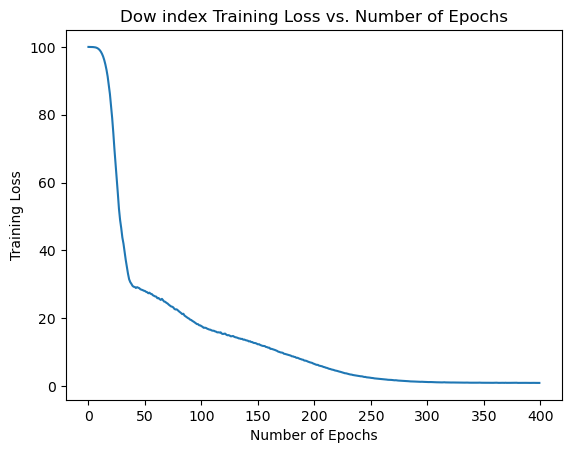

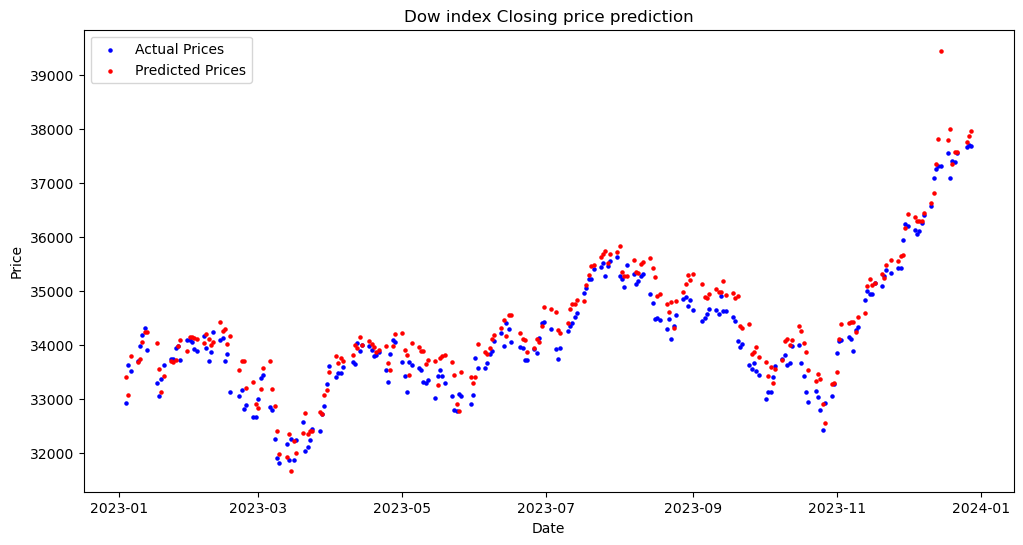

In [22]:
ANN_model_testing('Dow',history_dow,model_dow,X_test_dow,y_test_dow)

### S&P500 Index

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0188  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model Validation Loss is: 1.01%


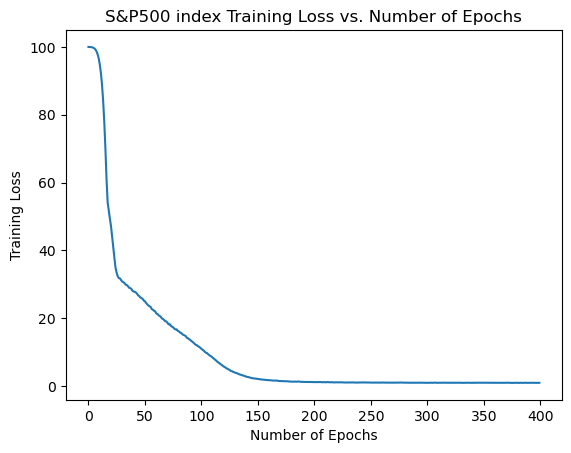

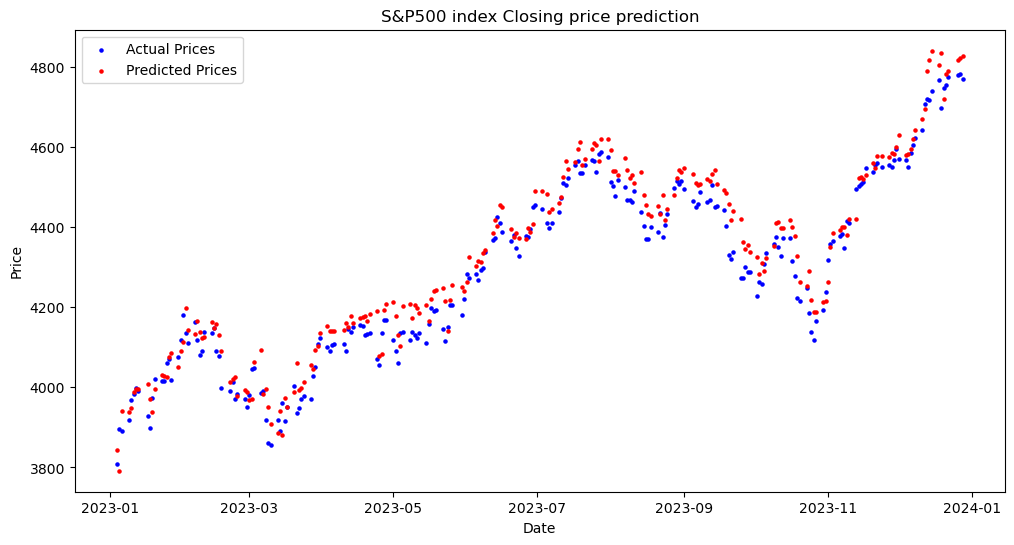

In [23]:
ANN_model_testing('S&P500',history_sp5,model_sp5,X_test_sp5,y_test_sp5)

### Nasdaq 100 Index

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3040  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Validation Loss is: 1.24%


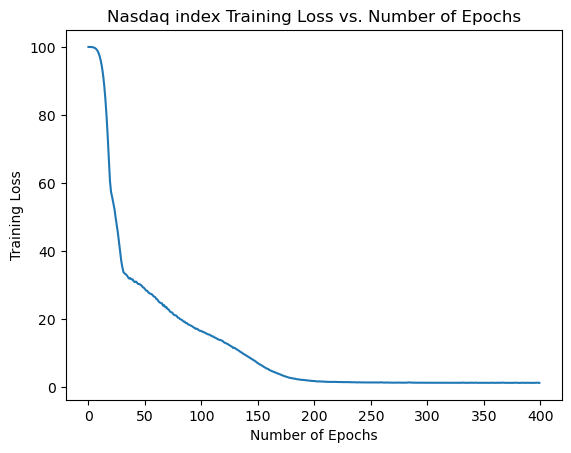

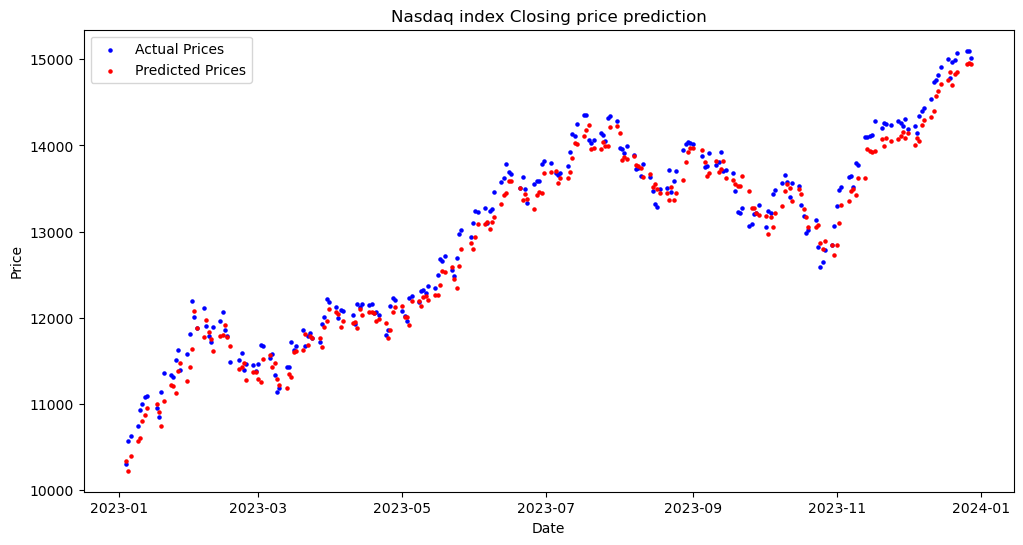

In [24]:
ANN_model_testing('Nasdaq',history_nasd,model_nasd,X_test_nasd,y_test_nasd)

### Result Analysis

**Observations** - We have tried different batch size and epochs. Choosing 400 epochs and 64 batch size work well in our case.  Training loss reduces rapidly in the start and then the model gets converged. Training errors are below 1% for all three models. We have tested these individual models on the testing data for each index. Below results section highlights the testing accuracy.

**Results** - The ANN model is able to successfully forecast the next day closing price of Dow, S&P 500 and Nasdaq index. We get 1.42% error for Dow index. S&P500 index forecast error is around 0.91% and for Nasdaq the error is 1.05%. Overall, on average 1% forecasting error is observed. Given the non-linearity in timeseries the model performance is superior.

We have also calculated the index volatility above. Results are as follows - 

 - Dow index volatility is: 20.93%
 - S&P500 index volatility is: 21.35%
 - Nasdaq index volatility is: 25.16%%

The Nasdaq Composite and the S&P 500 cover more sectors and more stocks in their portfolio, while the Dow is a blue-chip index for 30 stocks. We could see that Nasdaq is slightly higher volatile compared to other two indicies. Given the volatility, model performance is very good for all three indices.

Below table shows the overall model summary and total numbers of parameters.

In [25]:
model_dow.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,525 (21.59 KB)

 Trainable params: 1,841 (7.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,684 (14.39 KB)

 ### Use of Genetic Algorithm to optimise ANN weights

First, we train the neural network having two hidden layers and one output layer with one neuron. The hidden layer has 10 and 5 neurons respectively. Here, we are using Relu activation function. The network weights are optimised using evolutionary genetic algorithm. Genetic algorithm has three important steps selection, mutation and crossover.

We are using steady state selection, adaptive mutation and two-point crossover techniques. We have tried other variables also but this combination works best.

In [26]:
# The below function takes dataframe as input.
# The dataframe is divided into training data (80%) and testing data (20%)
# Here, we use min-max scaler to transform the features
# Then we define the neural network architecture with two hidden layers having 10 nd 5 neurons respectively.
# Genetic algorithm has three components - Selection, Mutation and Crossover
# Generation - 250
# Number of sols - 40

# This function returns model, instance and train-test data splits.

# function takes two inputs features and target
def GANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']

    # Scale the input features using MinMax scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
        
    # Data inputs
    data_inputs = X_train
    n_cols = data_inputs.shape[1]

    # Data outputs
    data_outputs = np.array(y_train)
    
    # Define the model using functional API
    # 2 Hidden layers
    tf.keras.backend.clear_session()
    input_layer  = tf.keras.layers.Input((n_cols,))
    dense_layer1 = tf.keras.layers.Dense(10, activation="relu")(input_layer)
    dense_layer1.trainable = True
    dense_layer2 = tf.keras.layers.Dense(5, activation="relu")(dense_layer1)
    dense_layer2.trainable = True
    output_layer = tf.keras.layers.Dense(1, activation="linear")(dense_layer2)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    
    # ANN model initialisation
    keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=40)
    
    #fitness function over the generation 
    def fitness_func(ga_instanse, solution, sol_idx):
        nonlocal data_inputs, data_outputs, keras_ga, model
        
        predictions = pygad.kerasga.predict(model=model,
                                            solution=solution,
                                            data=data_inputs,
                                            batch_size = 500)
        
        # MAPE (Mean Absolute Percentage Error
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        abs_error = mape(data_outputs, predictions).numpy() + 0.00000001
        solution_fitness = 100.0 / abs_error

        return solution_fitness

    def on_generation(ga_instance):
        print(f"Generation = {ga_instance.generations_completed}")
        print(f"Fitness    = {ga_instance.best_solution()[1]}")
    
    #prepare the genetic algorithm parameters
    num_generations =    250    # Number of generations.
    num_parents_mating = 2  # Number of solutions to be selected as parents in the mating pool.
    initial_population = keras_ga.population_weights # Initial population of network weights

    mutation_probability = [0.4, 0.25]
    parent_selection_type = "sss" # Type of parent selection. #sss
    crossover_type = "two_points" # Type of the crossover operator
    mutation_type = "adaptive"  # Type of the mutation operator
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents.

    ga_instance = pygad.GA(num_generations=num_generations, 
                           num_parents_mating=num_parents_mating, 
                           initial_population=initial_population,
                           fitness_func=fitness_func,
                           parent_selection_type=parent_selection_type,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_probability = mutation_probability,
                           keep_parents=keep_parents,
                           on_generation=on_generation)

    ga_instance.run()

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print(f"Fitness value of the best solution = {solution_fitness}")
    
    return model, ga_instance, solution, X_train, X_test, y_train, y_test

### DOW index training

In [ ]:
ga_model_dow, ga_ins_dow, ga_sol_dow, X_train_dow, X_test_dow, y_train_dow, y_test_dow = GANN_model(df = dow)

C:\Users\hjeen\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 1.000868291628437
Generation = 2
Fitness    = 1.001316657354512
Generation = 3
Fitness    = 1.0021967400381238
Generation = 4
Fitness    = 1.0036304572719694
Generation = 5
Fitness    = 1.004976347240272


### S&P500 index training

In [ ]:
ga_model_sp5, ga_ins_sp5, ga_sol_sp5, X_train_sp5, X_test_sp5, y_train_sp5, y_test_sp5 = GANN_model(df = sp5)

### Nasdaq-100 index training

In [ ]:
ga_model_nasd, ga_ins_nasd, ga_sol_nasd, X_train_nasd, X_test_nasd, y_train_nasd, y_test_nasd = GANN_model(df = nasdaq)

### Genetic algorithm model Testing

Here, we will test our genetic model. First chart shows the fitness improvement over generations. Then we print Model validation loss for each model. Lastly, we plot the actual vs predicted prices for each index.

In [ ]:
# Test the ANN model.
# Input to the function - model, instance, best solution and testing dataset
# return the testing performance and charts.
def GA_model_testing(model,instance,solution,x_feature,y_target,index_name, type):  
    
    # predict the model output
    predictions = pygad.kerasga.predict(model=model,
                                        solution=solution,
                                        data=x_feature)
    
    #calculate MAPE statistics
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    abs_error = mape(y_target, predictions).numpy()

    if(type == "train"):
        regressorName = index_name + " Genetic Algorithm - Iteration vs. Fitness"
        instance.plot_fitness(title=regressorName, color = '#1f77b4')

    # Trim the validation loss to two decimal places
    trimmed_val_loss = "{:.2f}".format(abs_error)

    print(f"Model Validation Loss is: {trimmed_val_loss}%")

    # plot the actual vs predicted time-series

    # x-axis for validation plot
    x_ax = list(y_target.index)
    if(type == "train"):
        regressorName = index_name + " index Training Closing price prediction"
    else:
        regressorName = index_name + " index Testing Closing price prediction"
    plt.figure(figsize=(12, 6))  # Wide figure
    plt.scatter(x_ax, y_target, label='Actual Prices',color='blue',s=5)
    plt.scatter(x_ax, predictions, label='Predicted Prices',color='red',s=5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    
    return predictions

### Dow Index

In [ ]:
dow_pred = GA_model_testing(ga_model_dow, ga_ins_dow, ga_sol_dow, X_train_dow,  y_train_dow,'Dow','train')

In [ ]:
dow_pred = GA_model_testing(ga_model_dow, ga_ins_dow, ga_sol_dow, X_test_dow,  y_test_dow,'Dow','test')

### S&P500 Index

In [ ]:
sp5_pred  = GA_model_testing(ga_model_sp5, ga_ins_sp5, ga_sol_sp5, X_train_sp5,  y_train_sp5,'SP5','train')

In [ ]:
sp5_pred  = GA_model_testing(ga_model_sp5, ga_ins_sp5, ga_sol_sp5, X_test_sp5,  y_test_sp5,'SP5','test')

### Nasdaq 100 Index

In [ ]:
nasd_pred  = GA_model_testing(ga_model_nasd, ga_ins_nasd, ga_sol_nasd, X_train_nasd,  y_train_nasd,'Nasdaq','train')

In [ ]:
nasd_pred  = GA_model_testing(ga_model_nasd, ga_ins_nasd, ga_sol_nasd, X_test_nasd,  y_test_nasd,'Nasdaq','test')

### Result Analysis

**Observations** - We have tried using different parent selection and crossover techniques. Choosing steady syate selection and two-point crossover works best in our case. We have tested these individual models on the testing data for each index. Below results section highlights the testing accuracy.

Traning errors are as below:

 - Dow index: 0.99%
 - S&P500 index: 1.06%
 - NASDAQ100 index: 1.32%

Testing errors are as below:

 - Dow index: 0.71%
 - S&P500 index: 1.43%
 - NASDAQ100 index: 0.95%

**Results** - The hybrid model is able to successfully forecast the next day closing price of Dow, S&P 500 and Nasdaq index. On avergae, we get around 1% testing error in the forecasting. Testing accuracy is good for Dow and Nasdaq index. Given the non-linearity in timeseries the model performance is superior.

The Nasdaq Composite and the S&P 500 cover more sectors and more stocks in their portfolio, while the Dow is a blue-chip index for 30 stocks. We could see that Nasdaq is slightly higher volatile compared to other two indicies. Given the volatility, model performance is very good for all three indices.

### Model Strategy Builder

Using the test data we will compute the returns of 3 strategies. We have incorporated 0.1% transaction cost and 0.1% trading slippage.

Buy and hold: simply buys the stock at the beginning of the test period and holds it until the end.

Long-only: this strategy either goes long in the stock (if the predicted next day return is positive) or goes to cash (with a 0% return associated).

Long/Short this strategy goes long (short) in the stock when the next day ahead return predicted by the model is positive (negative)


In [ ]:
# the function takes index name and prediction as inputs.
# we create three strategies Long only, Buy & hold, Long and short
# The function returns strategy performance over the testing period
# The function also plot the strategy returns over the testing period.

def strategy_eval(index_name, index_pred, title):
    test_dow = index_name[index_name.index >= '2023-01-04'][['Close', 'ROC']]
    test_dow["Pred"] = index_pred.flatten()
    test_dow["Pred"] = ( test_dow["Pred"] - test_dow["Close"]  ) / test_dow["Close"]
    test_dow = test_dow.rename(columns={'ROC': 'Ret'})
    
    test_dow.Date = pd.to_datetime(test_dow.index, format="%YYYY-%mm-%dd")
    test_dow = test_dow.reset_index()
    df = test_dow[['Date','Ret','Pred']]
    
    df["Positions"] = np.where(df["Pred"] > 0, 1, -1)
    df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
    df["Positions_L"] = df["Positions"].shift(1)
    df["Positions_L"][df["Positions_L"] == -1] = 0
    df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]

    # Define transaction costs and slippage (as percentages)
    transaction_cost = 0.001  # 0.1% per trade
    slippage = 0.001  # 0.1% per trade

    # Calculate transaction costs and slippage per trade
    df['transaction_cost_S'] = df['Strat_ret'].abs() * transaction_cost
    df['slippage_S'] = df['Strat_ret'].abs() * slippage

    df['transaction_cost_L'] = df['Strat_ret_L'].abs() * transaction_cost
    df['slippage_L'] = df['Strat_ret_L'].abs() * slippage

    df['transaction_cost'] = df['Ret'].abs() * transaction_cost
    df['slippage'] = df['Ret'].abs() * slippage

    df['Strat_ret'] = df['Strat_ret'] - df['transaction_cost_S'] - df['slippage_S']
    df['Strat_ret_L'] = df['Strat_ret_L'] - df['transaction_cost_L'] - df['slippage_L']
    df['Ret'] = df['Ret'] - df['transaction_cost'] - df['slippage']

    df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    
    Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
    Final_Return = np.prod(1 + df["Strat_ret"]) - 1
    Buy_Return = np.prod(1 + df["Ret"]) - 1
    
    print("Strat Return Long Only =", Final_Return_L * 100, "%")
    print("Strat Return =", Final_Return * 100, "%")
    print("Buy and Hold Return =", Buy_Return * 100, "%")
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    df.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
    df.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
    df.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
    plt.xlabel("date")
    plt.ylabel("Cumulative Returns")
    plt.title(title)
    plt.grid()
    plt.show()
    
    return
    

In [ ]:
strategy_eval(dow, dow_pred, "Dow index strategy performance")

In [ ]:
strategy_eval(sp5, sp5_pred, "S&P500 index strategy performance")

In [ ]:
strategy_eval(nasdaq, nasd_pred, "NASDAQ100 index strategy performance")

The hybrid model does a decent job in timing all the three indices. We have incorporated both transaction cost and trading slippage in our calculation. Given the higher volatility nature of the indices strategy return performance is quite good. Although the Long only or Long/Short strategy is not able to beat the Buy & hold strategy return but overall returns are above 10% in all cases.
 - Hybrid model outperform the ANN model.
 - Hybrid model has simple architecture than ANN model and around 50% of less training parameters. In hybrid model, we have 2 hidden layers only and numbers of neurons are half of ANN mode.


### Advantages of Genetic Algorithms


 - Genetic algorithms can solve highly complex problems that are otherwise too difficult to solve using traditional optimization algorithms.
 - It has a high probability of finding the global minima and not getting stuck to local minima.
 - Genetic algorithms don’t need derivative information.

### Limitations of Genetic Algorithms

 - Genetic algorithms are highly computationally expensive to run.
 - Initial choice os solution play a critical role in determining how quickly algorithm reaches the desired result.
 - The genetic algorithm can be time-consuming as it can take much time to converge.